In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy



In [2]:

'''
# 将label和像素数据分离
path = 'project2_train.csv'
df = pd.read_csv(path)
# 提取label数据
df_y = df[['label']]
# 提取feature（即像素）数据
df_x = df[['feature']]
# 将label写入label.csv
df_y.to_csv('label.csv', index=False, header=False)
# 将feature数据写入data.csv
df_x.to_csv('data.csv', index=False, header=False)
# 读取像素数据
'''

In [2]:
x = np.loadtxt('data.csv')
y= np.loadtxt('label.csv')

In [3]:
x=x.reshape(28709,1,48,48)
x.shape

(28709, 1, 48, 48)

In [4]:
X_train=x[0:20001]
X_test=x[20001:]
y_train=y[0:20001]
y_test=y[20001:]


In [5]:
X_train_tor=torch.from_numpy(X_train.astype(np.float32))
X_test_tor=torch.from_numpy(X_test.astype(np.float32))
y_train_tor=torch.from_numpy(y_train.astype(np.int64))
y_test_tor=torch.from_numpy(y_test.astype(np.int64))

In [6]:
train_data=Data.TensorDataset(X_train_tor,y_train_tor)
#test_data=Data.TensorDataset(X_test_tor,y_test_tor)

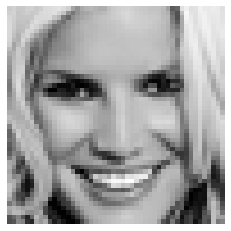

In [7]:
fig, ax = plt.subplots(num="myimage")
ax.imshow(X_train[210].reshape(48,48), cmap="gray")
ax.axis('off')
plt.show()

In [55]:
#设计数据加载器
train_loader=Data.DataLoader(
    dataset=train_data
    ,batch_size=512
    , shuffle=True
)

In [56]:
len(train_loader)

40

In [57]:
#设计特殊的5个核函数用来检测区别
kersize=3
ker1=torch.ones(kersize,kersize,dtype=torch.float32)*-1
ker1[1,1]=9

ker2=torch.ones(kersize,kersize,dtype=torch.float32)
ker2[:,1]=ker2[:,1]*0
ker2[:,1]=ker2[:,2]*-1

ker3=torch.ones(kersize,kersize,dtype=torch.float32)*-1
ker3[:,1:1]=ker3[:,1:1]*0
ker3[:,2:2]=ker3[:,2:2]*-1

ker4=torch.ones(kersize,kersize,dtype=torch.float32)*-1
ker4[1]=ker4[:,1]*0
ker4[2]=ker4[2]*-1

ker5=torch.ones(kersize,kersize,dtype=torch.float32)
ker5[1]=ker5[:,1]*0
ker5[2]=ker5[2]*-1

In [58]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Sequential(
             nn.Conv2d(
                     in_channels=1
                    ,out_channels=16
                    ,kernel_size=7
                    ,stride=1
#                    ,padding=1
             )
#            ,nn.ReLU()
            ,nn.MaxPool2d(
                kernel_size=3
                ,stride=3
            )
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                     in_channels=16
                    ,out_channels=64
                    ,kernel_size=4
                    ,stride=1
#                    ,padding=1
             )
            ,nn.MaxPool2d(
                kernel_size=3
                ,stride=2
            )
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                     in_channels=64
                    ,out_channels=256
                    ,kernel_size=2
                    ,stride=1
#                    ,padding=1
             )
#            ,nn.ReLU()
            ,nn.MaxPool2d(
                 kernel_size=2
                ,stride=2
            )
        )
        self.classifier=nn.Sequential(
            nn.Linear(256*2*2,256)
            ,nn.ReLU()
            ,nn.Dropout(p=0.2)
            ,nn.Linear(256,32)
            ,nn.ReLU()
#            ,nn.Dropout(p=0.5)
            ,nn.Linear(32,7)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x=x.view(x.size(0),-1)
        output=self.classifier(x)
        return output

In [63]:
#设计优化器
myconvnet=MyConvNet()
optimizer=torch.optim.Adam(myconvnet.parameters(), lr=0.0003,weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [64]:
print(myconvnet)

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 256, kernel_size=(2, 2), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=7, bias=True)
  )
)


In [65]:
#将网络模块，数据加载器，优化器，损失函数整合
def  train_model(
     model
    ,traindataloader
    ,X_test
    ,y_test
#    ,train_rate
    ,criterion
    ,optimizer
    ,num_epochs=100
):
    batch_num=len(traindataloader)
    train_loss_all=[]
    train_acc_all=[]    
    test_loss_all=[]
    test_acc_all=[]
    
    for epoch in range(num_epochs):
        print('Epoch {} /{} '.format(epoch,num_epochs))
        print('-'*20)
        train_loss=0.0
        train_corrects=0
        train_num=0
        test_loss=0.0
        acc=0.0
        
        for step,(b_x,b_y) in enumerate(traindataloader):
            if step<batch_num:
                model.train()
                output=model(b_x)
                pre_lab=torch.argmax(output,1)
                
                loss=criterion(output,b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss+=loss.item()*b_x.size(0)
                train_corrects+=torch.sum(pre_lab==b_y.data)
                train_num+=b_x.size(0)
                
        model.eval()
        output=myconvnet(X_test)
        pre_lab=torch.argmax(output,1)
        acc=accuracy_score(y_test,pre_lab)
        test_loss=loss.item()
                
        train_loss_all.append(train_loss /train_num)
        train_acc_all.append(train_corrects.double().item() /train_num)
        test_loss_all.append(test_loss)
        test_acc_all.append(acc)
        print('{} Train Loss: {:.4f}     Train Acc : {:.4f}'.format(epoch,train_loss_all[-1],train_acc_all[-1]))
        print('{} Test Loss: {:.4f}     Test Acc : {:.4f}'.format(epoch,test_loss_all[-1],test_acc_all[-1]))
        
    train_process=pd.DataFrame(
        data={"epoch":range(num_epochs)
                ,"train_loss_all":train_loss_all
                ,"train_acc_all":train_acc_all
                ,"test_loss_all":test_loss_all
                ,"test_acc_all":test_acc_all
             }   
   )
    return model,train_process

In [66]:
myconvnet,train_process=train_model(
     myconvnet
    ,train_loader
    ,X_test_tor
    ,y_test_tor
    ,criterion
    ,optimizer
    ,num_epochs=100
)

Epoch 0 /100 
--------------------
0 Train Loss: 2.0002     Train Acc : 0.2274
0 Test Loss: 1.7183     Test Acc : 0.2737
Epoch 1 /100 
--------------------
1 Train Loss: 1.7668     Train Acc : 0.2786
1 Test Loss: 1.6305     Test Acc : 0.3294
Epoch 2 /100 
--------------------
2 Train Loss: 1.7039     Train Acc : 0.3287
2 Test Loss: 1.8132     Test Acc : 0.3675
Epoch 3 /100 
--------------------
3 Train Loss: 1.6376     Train Acc : 0.3662
3 Test Loss: 1.6501     Test Acc : 0.4100
Epoch 4 /100 
--------------------
4 Train Loss: 1.5676     Train Acc : 0.4004
4 Test Loss: 1.6310     Test Acc : 0.4325
Epoch 5 /100 
--------------------
5 Train Loss: 1.5251     Train Acc : 0.4181
5 Test Loss: 1.7812     Test Acc : 0.4274
Epoch 6 /100 
--------------------
6 Train Loss: 1.4861     Train Acc : 0.4376
6 Test Loss: 1.6288     Test Acc : 0.4488
Epoch 7 /100 
--------------------
7 Train Loss: 1.4442     Train Acc : 0.4543
7 Test Loss: 1.5415     Test Acc : 0.4554
Epoch 8 /100 
------------------

67 Train Loss: 0.1224     Train Acc : 0.9703
67 Test Loss: 0.2099     Test Acc : 0.5274
Epoch 68 /100 
--------------------
68 Train Loss: 0.1550     Train Acc : 0.9572
68 Test Loss: 0.0748     Test Acc : 0.5272
Epoch 69 /100 
--------------------
69 Train Loss: 0.1092     Train Acc : 0.9755
69 Test Loss: 0.1012     Test Acc : 0.5245
Epoch 70 /100 
--------------------
70 Train Loss: 0.1267     Train Acc : 0.9691
70 Test Loss: 0.0742     Test Acc : 0.5237
Epoch 71 /100 
--------------------
71 Train Loss: 0.1042     Train Acc : 0.9769
71 Test Loss: 0.0877     Test Acc : 0.5211
Epoch 72 /100 
--------------------
72 Train Loss: 0.1035     Train Acc : 0.9772
72 Test Loss: 0.0551     Test Acc : 0.5230
Epoch 73 /100 
--------------------
73 Train Loss: 0.1007     Train Acc : 0.9776
73 Test Loss: 0.1056     Test Acc : 0.5246
Epoch 74 /100 
--------------------
74 Train Loss: 0.1253     Train Acc : 0.9685
74 Test Loss: 0.1406     Test Acc : 0.5201
Epoch 75 /100 
--------------------
75 Train

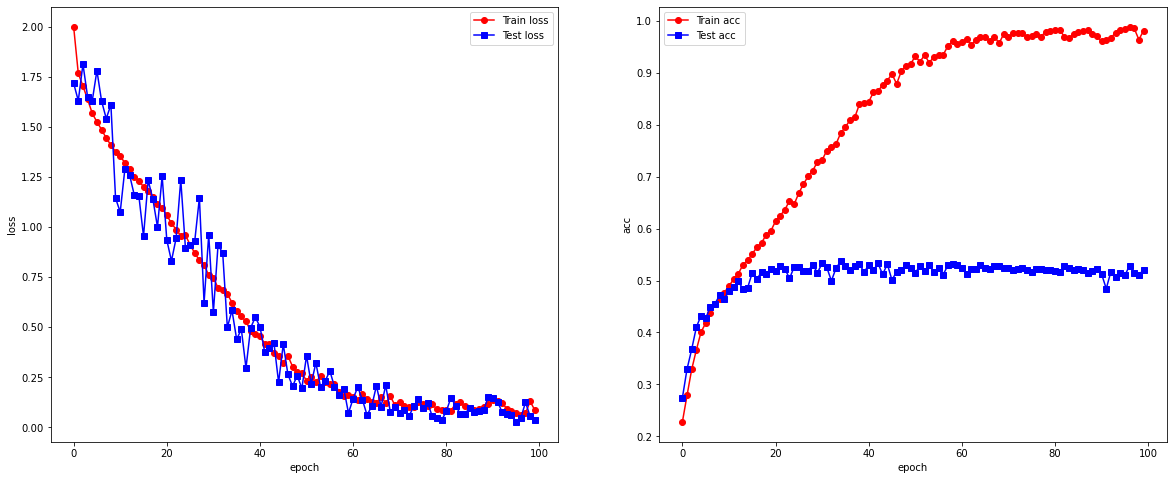

In [67]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,"ro-",label="Train loss")
plt.plot(train_process.epoch,train_process.test_loss_all,"bs-",label="Test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,"ro-",label="Train acc")
plt.plot(train_process.epoch,train_process.test_acc_all,"bs-",label="Test acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()

